In [193]:
# Copyright [2025] [KTH Royal Institute of Technology] 
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 1 for EL2805 - Reinforcement Learning.

# Load packages
import numpy as np
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import pickle

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

# Parameters
N_episodes = 200        # Number of episodes to run for training
discount_factor = 1.    # Value of gamma


# Reward
episode_reward_list = []  # Used to save episodes reward





# m = eta.shape[0]

# weights = np.random.normal(size=(m,3)) #(m,3)


In [194]:
# s = [0.2, 0.2]

# weights.T @ np.cos(2*np.pi*eta @ s)

# np.cos(2*np.pi*eta @ s)


class Model:

    def __init__(self, eta, lam, gamma):
        self.eta = eta #(m,2)
        self.m = eta.shape[0]
        self.weights = self.__init_weights(self.m) #(m,3)
        self.z = np.zeros((self.m,3))
        self.lam = lam
        self.gamma = gamma

    def forward(self, s):
        return self.weights.T @ np.cos(np.pi*self.eta @ s) # (3,)

    def __init_weights(self, m):
        return np.random.normal(size=(m,3)) #(m,3)
    
    def eps_greedy(self, s, eps):
        if np.random.rand() < 1-eps:
            return np.argmax(self.forward(s))
        else:
            return np.random.randint(3)

    def update_trace(self, s, a):
        self.z *= self.gamma*self.lam
        self.z[:, a] += np.cos(np.pi*self.eta @ s)

    def Phi(self, s):
        return np.cos(np.pi*self.eta @ s)

    def Q(self,s,a):
        return (self.weights.T @ self.Phi(s))[a]

    def update_weights(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.weights += alpha*delta*self.z

    def reset_trace(self):
        self.z = np.zeros((self.m,3))

    def save(self, file_name):
        d = {}
        d["N"] = self.eta
        d["W"] = self.weights.T

        with open(file_name, 'wb') as file:
            pickle.dump(d, file)




         


In [195]:

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x


In [ ]:

eta =np.array([[0, 1], [0, 2], [1, 1]]) #np.array([(i,j) for i in range(3) for j in range(3)]) # (m,2)
lam = 0.5
gamma = 1
model = Model(eta, lam, gamma) 

In [197]:
last_epsiode_pos = []
last_epsidoe_vel = []

In [198]:

# Training process
for i in range(N_episodes):
    # Reset enviroment data
    done = False
    truncated = False
    state = scale_state_variables(env.reset()[0])
    total_episode_reward = 0.

    eps = 0.1
    alpha = 0.1

    model.reset_trace()
    action =  model.eps_greedy(state, eps)

    while not (done or truncated):


        if i == N_episodes-1:
            last_epsiode_pos.append(state[0])
            last_epsidoe_vel.append(state[1])
            

        # Take a random action
        # env.action_space.n tells you the number of actions
        # available
        
        # Get next state and reward.  The done variable
        # will be True if you reached the goal position,
        # False otherwise. Truncated is true if you reach 
        # the maximal number of time steps, False else.
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = scale_state_variables(next_state)

        next_action = model.eps_greedy(next_state, eps)


        model.update_trace(state, action)
        model.update_weights(state, action, reward, next_state, next_action, alpha)

        # Update episode reward
        total_episode_reward += reward

            
        # Update state for next iteration
        state = next_state
        action = next_action

    # Append episode reward
    episode_reward_list.append(total_episode_reward)

    # Close environment
    env.close()
    

In [199]:
# import pickle


# with pickel.o

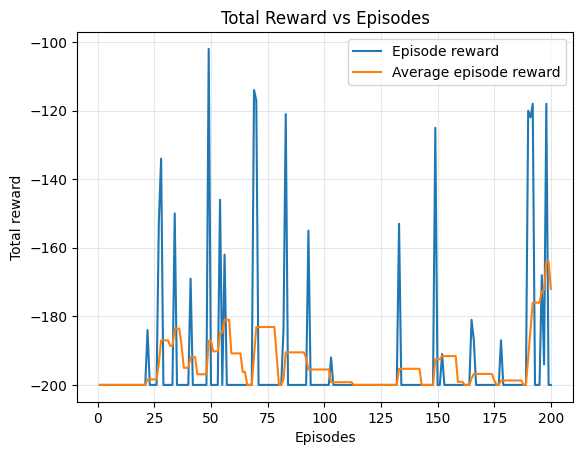

In [200]:

# Plot Rewards
plt.plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
plt.plot([i for i in range(1, N_episodes+1)], running_average(episode_reward_list, 10), label='Average episode reward')
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.title('Total Reward vs Episodes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [201]:
model.save("weights.pkl")